In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
from skopt import gp_minimize
import optuna
import random

In [2]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([int(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates
filename = "TSP-Configurations/a280.tsp.txt"
init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()

# Nearest Neighbour 

In [8]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step=100, init_seed=1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.max_step = max_step
        self.init_seed = init_seed
        self.step = 0

    def nearest_neighbor_heuristic(self):
        cities = list(self.cities_old.keys())
        current_city = random.choice(cities)
        solution = [current_city]

        while len(solution) < len(cities):
            distances = [(city, np.linalg.norm(np.array(self.cities_old[current_city]) - np.array(self.cities_old[city])))
                         for city in cities if city not in solution]
            next_city, _ = min(distances, key=lambda x: x[1])
            solution.append(next_city)
            current_city = next_city

        return OrderedDict((city, self.cities_old[city]) for city in solution)

    def proposal(self):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(self.cities_old.keys()))
        value = self.cities_old[random_key]

        proposal_cities = self.cities_old.copy()
        del proposal_cities[random_key]

        #Move it to here     
        new_index = np.random.randint(0, len(self.cities_old) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(self.cities_old.items())[:new_index] + [(random_key, value)] + list(self.cities_old.items())[new_index:])
        return proposal_cities


    def evaluate(self, cities, proposal_cities, T):
        delta_distance = total_distance(proposal_cities) - total_distance(cities)
        alpha_func = min(np.exp(-delta_distance / T), 1)
        return alpha_func

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            cities_new = proposal_cities
        else:
            cities_new = self.cities_old
        return cities_new

    def run(self):
        # Initial heuristic solution (nearest neighbor)
        initial_solution = self.nearest_neighbor_heuristic()
        self.cities_old = initial_solution

        while self.step < self.max_step:
            self.init_seed += 1
            T = (self.C * np.log(self.step + self.T0))**(-1)
            self.step += 1
            proposal_cities = self.proposal()
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new


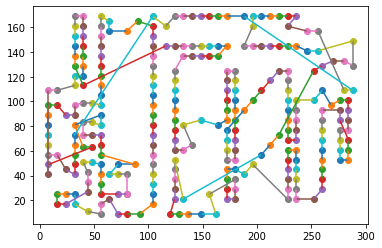

Total distance of simulated annealing solution is: 3288.023210946358
Order of the cities is as follows: odict_keys([84, 83, 82, 81, 80, 79, 76, 75, 74, 73, 72, 71, 70, 67, 66, 65, 64, 63, 62, 118, 61, 60, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 31, 30, 125, 124, 123, 122, 121, 120, 119, 157, 158, 159, 160, 175, 161, 162, 163, 164, 165, 166, 167, 168, 169, 101, 100, 99, 98, 93, 94, 95, 96, 97, 92, 91, 90, 89, 109, 108, 104, 103, 102, 170, 171, 172, 173, 106, 105, 107, 174, 110, 111, 114, 113, 87, 86, 116, 115, 117, 85, 88, 112, 77, 78, 69, 68, 58, 57, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 126, 127, 128, 21, 20, 19, 18, 17, 133, 132, 131, 130, 129, 154, 155, 153, 156, 152, 151, 177, 176, 181, 180, 179, 178, 150, 149, 139, 138, 137, 136, 135, 134, 270, 269, 268, 267, 266, 140, 141, 142, 143, 144, 145, 146, 147, 148, 265, 264, 263, 262, 261, 260, 259, 258, 257, 254, 253, 208, 207, 210, 209, 252, 255, 256, 249, 248, 247, 244, 241, 240, 239, 238, 231, 232, 233, 234, 235

In [15]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing(cities = init_cities, C = 0.95, T0 = 1000, max_step = 1000)
    cities_new = sim_annealing.run()
    visualize_routes(cities_new)
    print(f'Total distance of simulated annealing solution is: {total_distance(cities_new)}')
    print(f'Order of the cities is as follows: {cities_new.keys()}')

In [11]:
def objective_function(trial):
    # Define the hyperparameter search space
    C = trial.suggest_int('C', 0.1, 1000)
    T0 = trial.suggest_int('T0', 10, 5000)
    max_step = trial.suggest_int('max_step', 100, 2500)

    # Run the Simulated Annealing algorithm with the suggested hyperparameters
    sim_annealing = SimulatedAnnealing(init_cities, C, T0, max_step)
    cities_new = sim_annealing.run()
    distance = total_distance(cities_new)

    return distance

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the study
study.optimize(objective_function, n_trials=20, show_progress_bar=True)

# Extract the best parameters
best_params = study.best_params
best_value = study.best_value

# Print the best parameters
print("Best Parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Print the best objective value
print("Best Objective Value:", best_value)

[I 2023-12-11 16:45:29,258] A new study created in memory with name: no-name-22ccddcc-65d6-470d-8a8d-769d8d9ec06e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-11 16:45:30,449] Trial 0 finished with value: 3521.999708817391 and parameters: {'C': 543, 'T0': 1762, 'max_step': 282}. Best is trial 0 with value: 3521.999708817391.


/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_34849/3851093954.py:55: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-delta_distance / T), 1)


[I 2023-12-11 16:45:34,868] Trial 1 finished with value: 3191.3903055406345 and parameters: {'C': 780, 'T0': 2402, 'max_step': 1493}. Best is trial 1 with value: 3191.3903055406345.
[I 2023-12-11 16:45:35,879] Trial 2 finished with value: 3098.3682865341866 and parameters: {'C': 435, 'T0': 1827, 'max_step': 217}. Best is trial 2 with value: 3098.3682865341866.
[I 2023-12-11 16:45:39,509] Trial 3 finished with value: 3524.782805590287 and parameters: {'C': 842, 'T0': 1652, 'max_step': 1122}. Best is trial 2 with value: 3098.3682865341866.
[I 2023-12-11 16:45:42,043] Trial 4 finished with value: 3210.7266709017103 and parameters: {'C': 406, 'T0': 3362, 'max_step': 810}. Best is trial 2 with value: 3098.3682865341866.
[I 2023-12-11 16:45:43,016] Trial 5 finished with value: 3103.1339359133826 and parameters: {'C': 407, 'T0': 104, 'max_step': 227}. Best is trial 2 with value: 3098.3682865341866.
[I 2023-12-11 16:45:44,600] Trial 6 finished with value: 3247.713916994131 and parameters: {'C'